In [1]:
import logging
logging.basicConfig(level=logging.INFO)
from IPython.display import display

import numpy as np
from PIL import Image

import torch
import torchvision.models as M
import torchvision.transforms as T

import matplotlib.pyplot as plt

# Depth Estimation
with MiDaS

In [2]:
'''original source: https://github.com/niconielsen32/ComputerVision/blob/master/MonocularDepth/midasDepthMap.py
'''
import torch

# Load a MiDas model for depth estimation
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDas", model_type, trust_repo='check')

# Move model to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

# Load transforms to resize and normalize the image
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform


Using cache found in C:\Users\andris/.cache\torch\hub\intel-isl_MiDas_master
C:\Users\andris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\hub.py:266: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Using cache found in C:\Users\andris/.cache\torch\hub\intel-isl_MiDaS_master


In [3]:
import cv2

def generate_depth_map(img):
    # Apply input transforms
    input_batch = transform(img).to(device)

    # Prediction and resize to original resolution
    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth_map = prediction.cpu().numpy()
    return depth_map

## Single Image

(8.511125, 26.468573)


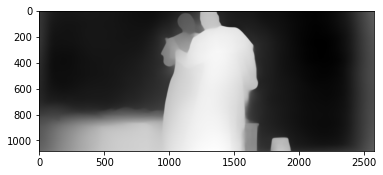

In [4]:
img = cv2.imread("E:/Mesterjatszma/Proxy/A043C011/A043C011.0409.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

depth_map = generate_depth_map(img)

#depth_map = cv2.normalize(depth_map, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)
#depth_map = cv2.normalize(depth_map, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

minmax = np.min(depth_map), np.max(depth_map)
print(minmax)
plt.imshow(cv2.cvtColor( cv2.normalize(depth_map, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) , cv2.COLOR_GRAY2RGB))

## Image Sequence

In [5]:
import imageio

imageio.plugins.freeimage.download()

In [ ]:

import cv2
from src.PathSequence import PathSequence
import imageio

seq = PathSequence.from_item_on_disk("E:/Mesterjatszma/Proxy/A043C011/A043C011.0409.jpg")

for i, path in enumerate(seq):
    print(path, "...")
    frame_number = i+seq._first_frame

    img = cv2.imread(str(path))
    h, w, c = img.shape
    img =  cv2.resize( img, (512,512) )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    depth_map = generate_depth_map(img)
    #depth_map = cv2.normalize(depth_map, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    rgb = cv2.cvtColor(depth_map/40.0,cv2.COLOR_GRAY2RGB)
    #rgb = np.uint8(rgb*255)

    output_filename = f"E:/Mesterjatszma/Proxy/A043C011/A043C011.depth_map.{frame_number:04}.exr"
    imageio.imwrite(output_filename, cv2.resize(rgb, (w, h)))
    #cv2.imwrite(output_filename, rgb)

: 